# Imports

In [1]:
# !pip install timm
# %pip install opencv-python
# %pip install torchsample

In [2]:
!pip install gdown 


In [3]:
!gdown https://drive.google.com/file/d/1clO-7w1PGTtHuKgVskiOcRDLq7JUzRTL/view?usp=share_link --fuzzy
    
print("Cropped folder downloaded")

!gdown https://drive.google.com/file/d/19YhNmiuJG8D4j-fptA0NTripq7bKDjRh/view?usp=share_link --fuzzy

print("Metadata Downloaded")


Downloading...
From (original): https://drive.google.com/uc?id=1clO-7w1PGTtHuKgVskiOcRDLq7JUzRTL
From (redirected): https://drive.google.com/uc?id=1clO-7w1PGTtHuKgVskiOcRDLq7JUzRTL&confirm=t&uuid=48c338b4-1314-4961-81e4-07165e815ca6
To: /kaggle/working/cropped.zip
100%|████████████████████████████████████████| 113M/113M [00:01<00:00, 64.2MB/s]
Cropped folder downloaded
Downloading...
From: https://drive.google.com/uc?id=19YhNmiuJG8D4j-fptA0NTripq7bKDjRh
To: /kaggle/working/metadata - standardized.csv
100%|███████████████████████████████████████| 1.75M/1.75M [00:00<00:00, 159MB/s]
Metadata Downloaded


In [4]:
!ls
!unzip -q cropped.zip



 __notebook__.ipynb   cropped.zip  'metadata - standardized.csv'


In [6]:
import os
import pickle
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight

import timm
from transformers import ViTForImageClassification, ViTImageProcessor



2024-04-22 06:26:23.145912: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-22 06:26:23.146007: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-22 06:26:23.259572: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
try:
    os.mkdir('models')
except:
    pass
try:
    os.mkdir('models/metrics')
except:
    pass

# Dataset Class

In [9]:

import os
import torch
from torch.utils.data import Dataset
from PIL import Image
from torchvision.transforms import Compose, Resize, ToTensor, Normalize, RandomHorizontalFlip, RandomRotation
import pandas as pd
import numpy as np
import cv2
from torchvision.transforms.functional import to_tensor

from torchvision.transforms import Compose, Resize, ToTensor
from torchvision.transforms.functional import to_pil_image, to_tensor
import cv2
from PIL import Image
import numpy as np


In [10]:

# Define custom transforms
class HistogramEqualization(object):
    def __call__(self, image):
        image_np = np.array(image)  # Convert PIL Image to numpy array
        image_eq = np.zeros_like(image_np)  # Initialize the output array
        
        # Check if the image has three channels (RGB)
        if image_np.ndim == 3 and image_np.shape[2] == 3:
            # Apply histogram equalization to each channel
            for channel in range(3):
                image_eq[:, :, channel] = cv2.equalizeHist(image_np[:, :, channel])
        else:
            # If the image is grayscale, apply histogram equalization directly
            image_eq = cv2.equalizeHist(image_np)
        
        image_eq_pil = Image.fromarray(image_eq)  # Convert numpy array back to PIL Image
        return image_eq_pil


class CLAHE(object):
    def __init__(self, clip_limit=2.0, tile_grid_size=(8, 8)):
        self.clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=tile_grid_size)

    def __call__(self, image):
        image_np = np.array(image)
        if image_np.ndim == 3 and image_np.shape[2] == 3:  # If it is RGB
            # Apply CLAHE to each channel separately
            channels = cv2.split(image_np)
            eq_channels = []
            for ch in channels:
                eq_channels.append(self.clahe.apply(ch))
            image_clahe = cv2.merge(eq_channels)
            image_clahe_pil = Image.fromarray(image_clahe)
            return image_clahe_pil
        else:
            # If the image is not RGB, apply CLAHE directly
            image_clahe = self.clahe.apply(image_np)
            image_clahe_pil = Image.fromarray(image_clahe)
            return image_clahe_pil


class GammaCorrection(object):
    def __init__(self, gamma):
        self.gamma = gamma

    def __call__(self, image):
        image_np = np.array(image)
        image_gamma = np.power(image_np / 255.0, self.gamma) * 255.0
        image_gamma = np.clip(image_gamma, 0, 255).astype(np.uint8)
        image_gamma_pil = Image.fromarray(image_gamma)
        return image_gamma_pil

In [11]:
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torch.utils.data import Dataset, Subset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
import os
from PIL import Image
import cv2

class GlaucomaDataset(Dataset):
    def __init__(self, root_dir, csv_file, image_dir='Images', transform=None, max_images=None):
        self.root_dir = root_dir
        self.csv_file = csv_file
        self.image_dir = image_dir
        self.transform = transform
        self.max_images = max_images
        
        if csv_file == "index.json":
            with open(os.path.join(root_dir, csv_file), 'r') as f:
                self.labels_dict = json.load(f)
            self.image_filenames = list(self.labels_dict.keys())
        elif csv_file == "metadata - standardized.csv":
            self.labels_df = pd.read_csv(os.path.join(root_dir, csv_file)) 
            # Filter DataFrame based on labels
            self.labels_df = self.labels_df[self.labels_df['types'].isin([0, 1])]
            
            print(len(self.labels_df))
            # Filter image_filenames based on labels
            self.image_filenames = [f for f in os.listdir(os.path.join(root_dir, image_dir)) if f.endswith('.png')]
            self.image_filenames = [f for f in self.image_filenames if f[:-4] in self.labels_df['names'].values]

 
        else:
            self.labels_df = pd.read_csv(os.path.join(root_dir, csv_file))
            self.image_filenames = [f for f in os.listdir(os.path.join(root_dir, image_dir)) if f.endswith('.jpg')]
            
        
        self.image_filenames = self.image_filenames[:max_images] if max_images is not None else self.image_filenames

        print(f'Successfully loaded dataset with {len(self.image_filenames)} images.')

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_dir, self.image_filenames[idx])
        img = cv2.imread(img_name)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
        img = Image.fromarray(img)  # Convert numpy array to PIL Image

        if self.transform:
            img = self.transform(img)
        if self.csv_file == 'G1020.csv':
            label = self.labels_df.loc[self.labels_df['imageID'] == self.image_filenames[idx], 'binaryLabels'].values[0]
        if self.csv_file == 'metadata - standardized.csv':
            label = self.labels_df.loc[self.labels_df['names']+".png" == self.image_filenames[idx], 'types'].values[0]        
        elif self.csv_file == 'OrigaList.csv':
            label = self.labels_df.loc[self.labels_df['Filename'] == self.image_filenames[idx], 'Glaucoma'].values[0]
        elif self.csv_file == "index.json":
            img_name = self.image_filenames[idx]  # Get the image name
            # Iterate through labels_dict to find matching entry
            for entry in self.labels_dict.values():
                if entry["ImgName"] == img_name:
                    label = entry["Label"]
                    break
               
            
        label_tensor = torch.tensor(label, dtype=torch.long)

        
        return img, label_tensor


# Define Transforms

In [12]:
from torchvision.transforms import RandomHorizontalFlip, RandomApply, RandomRotation

from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomRotation, ToTensor, Normalize, RandomResizedCrop
from torchvision.transforms import RandomAffine  # For more complex augmentations like scaling
import torchvision.transforms.functional as TF
import random

class RandomGammaCorrection:
    """Applies Random Gamma Correction."""
    def __init__(self, gamma_range=(0.7, 1.5)):
        self.gamma_range = gamma_range

    def __call__(self, img):
        gamma = random.uniform(*self.gamma_range)
        return TF.adjust_gamma(img, gamma)

train_transforms = Compose([
    Resize((512,512)),  # Slightly larger to allow for random crops
    RandomResizedCrop((312,312), scale=(0.8, 1.0)),  # Random scaling
#     HistogramEqualization(),
#     CLAHE(),
#     GammaCorrection(gamma=1.0),  # Adjust the gamma value as needed
    RandomHorizontalFlip(),
    RandomApply([RandomRotation(10)], p=0.5),
    RandomApply([RandomAffine(degrees=0, scale=(0.9, 1.1))], p=0.5),  # Random scaling
#     RandomGammaCorrection(gamma_range=(0.7, 1.5)),  # Random gamma correction for brightness adjustment
    Resize((312,312)),
    
    ToTensor(),
   Normalize(mean=[0.7538, 0.4848, 0.3553], std=[0.2417, 0.1874, 0.2076]),
])


# Define validation transformations without augmentation
val_transforms = Compose([
    Resize((312,312)),
#     HistogramEqualization(),
#     CLAHE(),
 #   GammaCorrection(gamma=1.0),  # Adjust the gamma value as needed
    ToTensor(),
   Normalize(mean=[0.7538, 0.4848, 0.3553], std=[0.2417, 0.1874, 0.2076]),
])


# Loading Dataset

In [13]:
batch_size=64
num_classes = 2


In [14]:
from torch.utils.data import DataLoader, WeightedRandomSampler
import torch

def get_balanced_loader(dataset, batch_size, oversample_factor=5):
    # Calculate weights for each sample
    labels = [dataset[i][1].item() for i in range(len(dataset))]
    class_count = [labels.count(0), labels.count(1)]
    weight_per_class = [1. / count for count in class_count]
    weights = [weight_per_class[label] for label in labels]
    
    # Adjust weights for oversampling
    for i, label in enumerate(labels):
        if label == 1:
            weights[i] *= (oversample_factor*2)
        else:
            weights[i] *= (oversample_factor)
            
        
    
    # Create a WeightedRandomSampler to balance and oversample the dataset
    sampler = WeightedRandomSampler(weights, num_samples=len(weights), replacement=True)
    
    # Create and return the DataLoader
    return DataLoader(dataset, batch_size=batch_size, sampler=sampler,num_workers=os.cpu_count(), pin_memory=True)

# Load Refuge dataset

In [ ]:
# refuge_root_dir='/kaggle/input/glaucoma-datasets/REFUGE/'
# # refuge_image_dir='Images_Cropped'
# refuge_image_dir='Images'

# refuge_csv_file='index.json'

# refuge_train_dir=refuge_root_dir+"train"
# refuge_val_dir=refuge_root_dir+"val"


# # Initialize the datasets with appropriate transformations
# refuge_train_dataset = GlaucomaDataset(root_dir=refuge_train_dir, image_dir=refuge_image_dir,
#                                        csv_file=refuge_csv_file, transform=train_transforms)

# refuge_val_dataset = GlaucomaDataset(root_dir=refuge_val_dir, image_dir=refuge_image_dir,
#                                      csv_file=refuge_csv_file, transform=val_transforms)

# # dataloaders


# refuge_train_loader = get_balanced_loader(refuge_train_dataset, batch_size, oversample_factor=5)
# refuge_val_loader = DataLoader(refuge_val_dataset, batch_size=batch_size, shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# print("loaded refuge dataaset")

# Load G1020 dataset

In [ ]:
# G1020_root_dir='/kaggle/input/glaucoma-datasets/G1020'
# # G1020_image_dir='Images_Cropped/img'
# G1020_image_dir='Images'

# G1020_csv_file='G1020.csv'


# # Initialize the datasets with appropriate transformations
# G1020_train_dataset = GlaucomaDataset(root_dir=G1020_root_dir, image_dir=G1020_image_dir,
#                                       csv_file=G1020_csv_file, transform=train_transforms)

# G1020_val_dataset = GlaucomaDataset(root_dir=G1020_root_dir, image_dir=G1020_image_dir, 
#                                       csv_file=G1020_csv_file, transform=val_transforms)



# # Split dataset indices
# G1020_train_indices, G1020_val_indices = train_test_split(range(len(G1020_train_dataset)), test_size=0.3, random_state=42)

# # Create Subset for train and validation datasets
# G1020_train_dataset = Subset(G1020_train_dataset, G1020_train_indices)
# G1020_val_dataset = Subset(G1020_val_dataset, G1020_val_indices)

# # # DataLoader setup
# G1020_train_loader = get_balanced_loader(G1020_train_dataset, batch_size, oversample_factor=5)

# G1020_val_loader = DataLoader(G1020_val_dataset, batch_size=batch_size,
#                               shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# print("loaded G1020 dataaset")

## Load ORIGA dataset

In [ ]:
# origa_root_dir='/kaggle/input/glaucoma-datasets/ORIGA'
# # origa_image_dir='Images_Cropped'
# origa_image_dir='Images'

# origa_csv_file='OrigaList.csv'


# # Initialize the dataset
# # Initialize the datasets with appropriate transformations
# origa_train_dataset = GlaucomaDataset(root_dir=origa_root_dir, image_dir=origa_image_dir,
#                                 csv_file=origa_csv_file, transform=train_transforms)




# origa_val_dataset = GlaucomaDataset(root_dir=origa_root_dir, image_dir=origa_image_dir, 
#                                       csv_file=origa_csv_file, transform=val_transforms)



# # Split dataset indices
# origa_train_indices, origa_val_indices = train_test_split(range(len(origa_train_dataset)), test_size=0.3, random_state=42)

# # Create Subset for train and validation datasets
# origa_train_dataset = Subset(origa_train_dataset, origa_train_indices)
# origa_val_dataset = Subset(origa_val_dataset, origa_val_indices)

# # # DataLoader setup
# origa_train_loader = get_balanced_loader(origa_train_dataset, batch_size, oversample_factor=5)

# origa_val_loader = DataLoader(origa_val_dataset, batch_size=batch_size,
#                               shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

# print("loaded origa dataaset")



# Loading SMDG Dataset instead of the above datasets 

In [ ]:
# smdg_root_dir='/kaggle/input/multichannel-glaucoma-benchmark-dataset/'
# # origa_image_dir='Images_Cropped'
# smdg_image_dir='full-fundus/full-fundus'

# smdg_csv_file='metadata - standardized.csv'


smdg_root_dir="/kaggle/working/"
smdg_image_dir='cropped'

smdg_csv_file='metadata - standardized.csv'


# Initialize the dataset
# smdg_dataset = GlaucomaDataset(root_dir=smdg_root_dir, image_dir=smdg_image_dir,
#                                 csv_file=smdg_csv_file, )


# Initialize the datasets with appropriate transformations
smdg_train_dataset = GlaucomaDataset(root_dir=smdg_root_dir, image_dir=smdg_image_dir,
                                csv_file=smdg_csv_file, transform=train_transforms)




smdg_val_dataset = GlaucomaDataset(root_dir=smdg_root_dir, image_dir=smdg_image_dir, 
                                      csv_file=smdg_csv_file, transform=val_transforms)



# Split dataset indices
smdg_train_indices, smdg_val_indices = train_test_split(range(len(smdg_train_dataset)), test_size=0.3, random_state=42)

# Create Subset for train and validation datasets
smdg_train_dataset = Subset(smdg_train_dataset, smdg_train_indices)
smdg_val_dataset = Subset(smdg_val_dataset, smdg_val_indices)

# # DataLoader setup
# smdg_train_loader = get_balanced_loader(smdg_train_dataset, batch_size, oversample_factor=5)


smdg_train_loader = DataLoader(smdg_train_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=os.cpu_count(), pin_memory=True)
smdg_val_loader = DataLoader(smdg_val_dataset, batch_size=batch_size,
                              shuffle=False, num_workers=os.cpu_count(), pin_memory=True)

print("loaded smdg dataaset")



12316
Successfully loaded dataset with 12285 images.
12316
Successfully loaded dataset with 12285 images.
loaded smdg dataaset


In [ ]:
means = []
stds = []

transform = transforms.ToTensor()


for img, _ in tqdm(smdg_dataset):
    
    img = transform(img)
    means.append(torch.mean(img, dim=(1,2)))
    stds.append(torch.std(img, dim=(1,2)))

mean = torch.mean(torch.stack(means), dim=0)
std = torch.mean(torch.stack(stds), dim=0)


print(mean)
print(std)


full fundus images
mean= tensor([0.9014, 0.5266, 0.2589])
std= tensor([0.0653, 0.1169, 0.0583])

Cropped discs
mean= tensor([0.7538, 0.4848, 0.3553])
std= tensor([0.2417, 0.1874, 0.2076])

In [ ]:
# train_loaders=[origa_train_loader,refuge_train_loader,G1020_train_loader]
# val_loaders=[origa_val_loader,refuge_val_loader,G1020_val_loader]

# dataset_name=["Origa", "Refuge", "G1020"]


train_loaders=[smdg_train_loader]

val_loaders=[smdg_val_loader]

dataset_name=["SMDG"]

# Check if correct masks and labels are loaded

## Train Loader

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# data_loader = DataLoader(dataset, num_workers=os.cpu_count(),batch_size=batch_size, shuffle=True)

# Number of images to display
n_images = 5

# Randomly select n_images from the dataset
indices = np.random.choice(len(train_subset), n_images, replace=False)
selected_images = [train_subset[i] for i in indices]

# Plot the images with their masks and labels
fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
if n_images == 1:
    axes = np.expand_dims(axes, 0)
for i, (img_with_mask, label) in enumerate(selected_images):
    # Extract the image and mask from the combined tensor
    img = img_with_mask 
    # mask = img_with_mask[3, :, :]

    # Convert the image and mask to NumPy arrays for plotting
    img_np = img.permute(1, 2, 0).numpy()
    # mask_np = mask.numpy()

    # Normalize image values to [0, 1] if they're not already
#     if img_np.max() > 1:
#         img_np = img_np / 255.0

    # Display image
    ax = axes[i, 0]
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f'Label: {label.item()}')

    # Display mask
    ax = axes[i, 1]
    # ax.imshow(mask_np, cmap='gray')
    ax.axis('off')
    ax.set_title('Mask')

    # Display image with mask overlaid
    ax = axes[i, 2]
    ax.imshow(img_np,cmap='gray',)
    # ax.imshow(mask_np, cmap='gray', alpha=0.5)
    ax.axis('off')
    ax.set_title('Image with Mask')

plt.tight_layout()
plt.show()


## Val Loader

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# data_loader = DataLoader(dataset, num_workers=os.cpu_count(),batch_size=batch_size, shuffle=True)

# Number of images to display
n_images = 5

# Randomly select n_images from the dataset
indices = np.random.choice(len(val_subset), n_images, replace=False)
selected_images = [val_subset[i] for i in indices]

# Plot the images with their masks and labels
fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
if n_images == 1:
    axes = np.expand_dims(axes, 0)
for i, (img_with_mask, label) in enumerate(selected_images):
    # Extract the image and mask from the combined tensor
    img = img_with_mask 
    # mask = img_with_mask[3, :, :]

    # Convert the image and mask to NumPy arrays for plotting
    img_np = img.permute(1, 2, 0).numpy()
    # mask_np = mask.numpy()

    # Normalize image values to [0, 1] if they're not already
#     if img_np.max() > 1:
#         img_np = img_np / 255.0

    # Display image
    ax = axes[i, 0]
    ax.imshow(img_np)
    ax.axis('off')
    ax.set_title(f'Label: {label.item()}')

    # Display mask
    ax = axes[i, 1]
    # ax.imshow(mask_np, cmap='gray')
    ax.axis('off')
    ax.set_title('Mask')

    # Display image with mask overlaid
    ax = axes[i, 2]
    ax.imshow(img_np)
    # ax.imshow(mask_np, cmap='gray', alpha=0.5)
    ax.axis('off')
    ax.set_title('Image with Mask')

plt.tight_layout()
plt.show()


## Origa test

In [ ]:
# import matplotlib.pyplot as plt
# import numpy as np

# # data_loader = DataLoader(dataset, num_workers=os.cpu_count(),batch_size=batch_size, shuffle=True)

# # Number of images to display
# n_images = 5

# # Randomly select n_images from the dataset
# indices = np.random.choice(len(origa_dataset), n_images, replace=False)
# selected_images = [origa_dataset[i] for i in indices]

# # Plot the images with their masks and labels
# fig, axes = plt.subplots(n_images, 3, figsize=(15, 5*n_images))
# if n_images == 1:
#     axes = np.expand_dims(axes, 0)
# for i, (img_with_mask, label) in enumerate(selected_images):
#     # Extract the image and mask from the combined tensor
#     img = img_with_mask 
#     # mask = img_with_mask[3, :, :]

#     # Convert the image and mask to NumPy arrays for plotting
#     img_np = img.permute(1, 2, 0).numpy()
#     # mask_np = mask.numpy()

#     # Normalize image values to [0, 1] if they're not already
# #     if img_np.max() > 1:
# #         img_np = img_np / 255.0

#     # Display image
#     ax = axes[i, 0]
#     ax.imshow(img_np, cmap='RdYlBu')
#     ax.axis('off')
#     ax.set_title(f'Label: {label.item()}')

# #     # Display mask
# #     ax = axes[i, 1]
# #     # ax.imshow(mask_np, cmap='gray')
# #     ax.axis('off')
# #     ax.set_title('Mask')

# #     # Display image with mask overlaid
# #     ax = axes[i, 2]
# #     ax.imshow(img_np)
# #     # ax.imshow(mask_np, cmap='gray', alpha=0.5)
# #     ax.axis('off')
# #     ax.set_title('Image with Mask')

# plt.tight_layout()
# plt.show()


# Hyper params

In [ ]:

# # Initialize class_counts
# class_counts = torch.zeros(num_classes)

# for train_loader in train_loaders:
#     for _, labels in tqdm(train_loader,"Loading"):
# #         print(labels)
#         # Assuming labels are directly accessible and not nested
#         # If labels are on GPU, you might need to bring them back to CPU for bincount
#         labels = labels.cpu()
#         class_counts += torch.bincount(labels, minlength=num_classes)

# # Calculate class frequencies and weights
# class_frequencies = class_counts / class_counts.sum()
# class_weights = 1.0 / class_frequencies
# class_weights /= class_weights.sum()

# # Assuming 'device' is defined (e.g., device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu"))
# class_weights = class_weights.to(device)

# print("Class Weights",class_weights)


# Training

In [ ]:
# print(num_classes)
# for loader_index in range(len(train_loaders)):
#     train_loader = train_loaders[loader_index]
#     print(train_loaders)
#     print(loader_index)
#     print(train_loader)

#     total_train_loss = 0
#     total_correct_train = 0
#     total_train_samples = 0

#     unique_labels = set()  # Initialize set to store unique labels

#     for batch in tqdm(train_loader,"calculating unique labels"):
#         _, labels = batch
        
#         # Print shapes of images and labels
# #         print(labels.shape)
# #         print(images.shape)

#         # Collect unique labels
#         unique_labels.update(labels.tolist())

# #         break  # Break after printing the first batch

#     print("Unique labels:", unique_labels)


In [ ]:


models_list = [
#     'inception_v3.tf_adv_in1k',
#     'tf_efficientnet_b0.ap_in1k',
#     'cspresnext50',
#     'densenet121',
#     'dla102',
#     'dpn107',
#     'ecaresnet101d',
#     'inception_resnet_v2',
#     'res2net101_26w_4s',
#     'resnet101d',
#     'wide_resnet101_2',
#     'resnet18',
#     'resnet34',
#     'densenet121',
#     'mobilenetv2_100',
     'efficientnet_b0',
#     'efficientnet_b1',
#     'efficientnet_b2',
 #    'efficientnet_b3',
#     'efficientnet_b4',
#      'efficientnet_b5',
#     'efficientnet_b6',
    
    
    
    
#      'seresnet50',
#     'seresnet101',
#    'seresnet152',
#     'seresnext50_32x4d',
#     'seresnext101_32x4d',
#     'densenet169',
#     'densenet201',
#     'inception_v3',
#     'inception_v4',
#     'resnest14d',
#     'resnest26d',
     #'resnest50d',
#     'swin_base_patch4_window7_224',
#     'deit_base_patch16_224',

#### Transformers 
#     'google/vit-base-patch16-224',
#     'google/vit-large-patch16-224',
    # 'deit_tiny_patch16_224',
    # 'deit_small_patch16_224',
    # 'deit_base_patch16_224',
    # 'deit_base_patch16_384',
    # Add more models as needed

    
]


In [ ]:
    # Training loop
num_epochs = 150
starting_patience = 0
lr=1e-5


print(f'Running {num_epochs} epochs each on {len(models_list)} models')

for i in range(len(models_list)):
        model_name=models_list[i]
        
        print(f"\n_______________{i+1}/{len(models_list)}_____{model_name}____________________\n")
        

        
        if "vit" in model_name:  # Check if the model is a Vision Transformer
            model = ViTForImageClassification.from_pretrained(
                model_name, 
                num_labels=num_classes, 
                ignore_mismatched_sizes=True
            )
            model.to(device)
            feature_extractor = ViTImageProcessor.from_pretrained(model_name)
        else:
            try:
                model = timm.create_model(model_name, num_classes=num_classes, pretrained=True)
            except:
                print("Couldnt load pretrained weights for ", model_name)
                model = timm.create_model(model_name, num_classes=num_classes, pretrained=False)
        
        model.to(device)

        
        # Initialize optimizer and learning rate scheduler
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True, )

        # Loss function

        criterion = torch.nn.CrossEntropyLoss()

        
        
        best_val_loss = float('inf')
        best_model_epoch=0
        patience = 11
        early_stopping_counter = 0


        train_loss_list = []
        val_loss_list = []
        train_accuracy_list = []
        val_accuracy_list = []

        
        
        for epoch in tqdm(range(num_epochs), desc='Epochs '):


            for loader_index in range(len(train_loaders)):
                train_loader=train_loaders[loader_index]


            
                model.train()
                
                total_train_loss = 0
                total_correct_train = 0
                total_train_samples = 0

                for batch in train_loader:
                    images, labels = batch


                    if "vit" in model_name:
                        images = feature_extractor(images, return_tensors="pt").to(device)
                    else:
                        images = images.to(device)



                    labels = labels.to(device)

                    # Forward pass
                    outputs = model(images)
                    loss = criterion(outputs, labels)

                    # Backward pass and optimization
                    optimizer.zero_grad()
                    loss.backward()
                    optimizer.step()

                    total_train_loss += loss.item()

                    _, predicted_train = torch.max(outputs, 1)
                    total_correct_train += (predicted_train == labels).sum().item()
                    total_train_samples += labels.size(0)

            avg_train_loss = (total_train_loss / len(train_loader))
            train_loss_list.append(avg_train_loss)

            train_accuracy = (total_correct_train / total_train_samples) *100
            train_accuracy_list.append(train_accuracy)
            
            for loader_index in range(len(val_loaders)):
                val_loader=val_loaders[loader_index]

                # Validation loop
                model.eval()
                total_val_loss = 0
                total_correct_val = 0
                total_val_samples = 0
                with torch.no_grad():
                    for batch in val_loader:
                        images, labels = batch
                        if "vit" in model_name:
                            images = feature_extractor(images, return_tensors="pt").to(device)
                        else:
                            images = images.to(device)
                        labels = labels.to(device)

                        # Forward pass
                        outputs = model(images)
                        loss = criterion(outputs, labels)

                        total_val_loss += loss.item()

                        _, predicted_val = torch.max(outputs, 1)
                        total_correct_val += (predicted_val == labels).sum().item()
                        total_val_samples += labels.size(0)

            avg_val_loss = total_val_loss / len(val_loader)
            val_loss_list.append(avg_val_loss)

            val_accuracy = (total_correct_val / total_val_samples) *100
            val_accuracy_list.append(val_accuracy)

            # Update learning rate
            scheduler.step(avg_val_loss)

            # Print loss and accuracy for the epoch
#             print(f"Best:{best_model_epoch},  Epoch {epoch + 1}/{num_epochs}, Train Loss: {avg_train_loss}, Train Accuracy: {train_accuracy :.2f}%, Val Loss: {avg_val_loss}, Val Accuracy: {val_accuracy :.2f}%")

            # Save model and lists if validation loss has improved
            if epoch >= starting_patience :
                if avg_val_loss < best_val_loss:
                    best_val_loss = avg_val_loss
                    best_model_epoch=epoch
                    torch.save(model.state_dict(), f"models/{model_name}_best_model.pth")
#                     print("Model saved")
                    # Also save the lists

                    early_stopping_counter = 0
                else:
                    early_stopping_counter += 1
                    if early_stopping_counter >= patience:
                        print("Early stopping at epoch ",epoch," with best model at ", best_model_epoch)
                        break
                        
        with open(f'models/metrics/{model_name}_training_metrics.pkl', 'wb') as f:
            pickle.dump({
                'train_loss_list': train_loss_list,
                'val_loss_list': val_loss_list,
                'train_accuracy_list': train_accuracy_list,
                'val_accuracy_list': val_accuracy_list,
                'best_model_epoch':best_model_epoch
            }, f)
        torch.cuda.empty_cache()    



Running 150 epochs each on 1 models

_______________1/1_____efficientnet_b0____________________



model.safetensors:   0%|          | 0.00/21.4M [00:00<?, ?B/s]

Epochs :  37%|███▋      | 55/150 [1:02:29<1:47:43, 68.04s/it]

Epoch 00055: reducing learning rate of group 0 to 1.0000e-06.


Epochs :  47%|████▋     | 70/150 [1:19:25<1:30:20, 67.76s/it]

Epoch 00070: reducing learning rate of group 0 to 1.0000e-07.


Epochs :  49%|████▉     | 74/150 [1:25:03<1:27:21, 68.97s/it]

Early stopping at epoch  74  with best model at  63


# Evaluation


____________________efficientnet_b0____________________

Best model loaded for efficientnet_b0
Metrics loaded for efficientnet_b0
Best epoch : 63


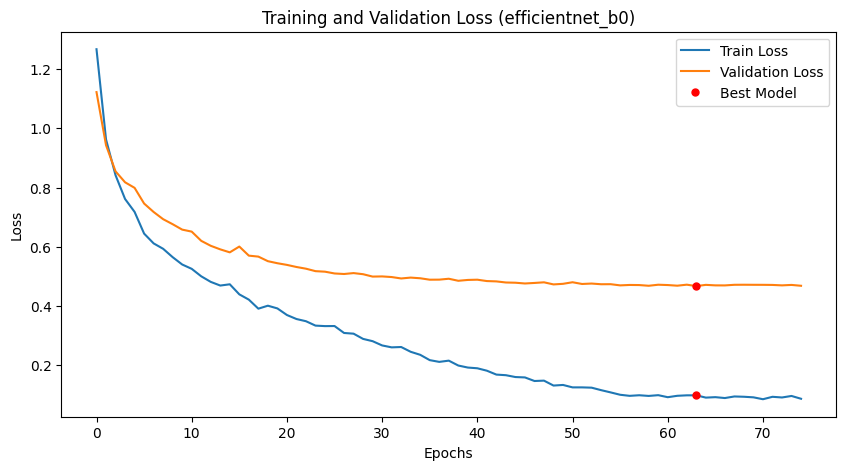

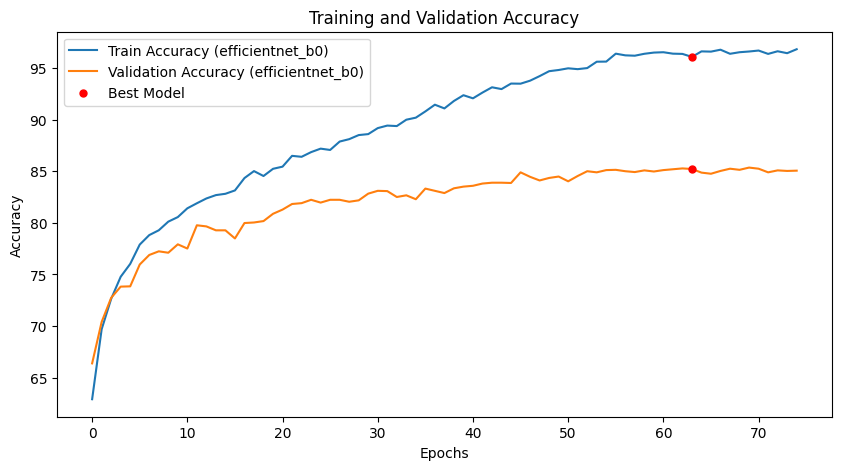

Validating on SMDG


Predicting on model: efficientnet_b0 and SMDG: 100%|██████████| 58/58 [00:12<00:00,  4.73it/s]


Classification Report:
 SMDG                precision    recall  f1-score   support

           0       0.88      0.88      0.88      2248
           1       0.81      0.81      0.81      1438

    accuracy                           0.85      3686
   macro avg       0.84      0.84      0.84      3686
weighted avg       0.85      0.85      0.85      3686



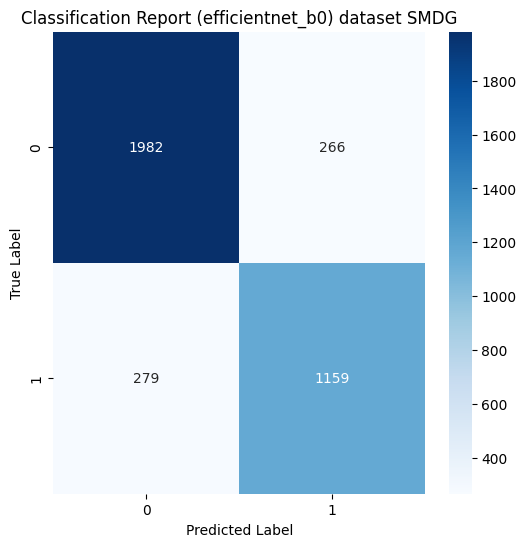

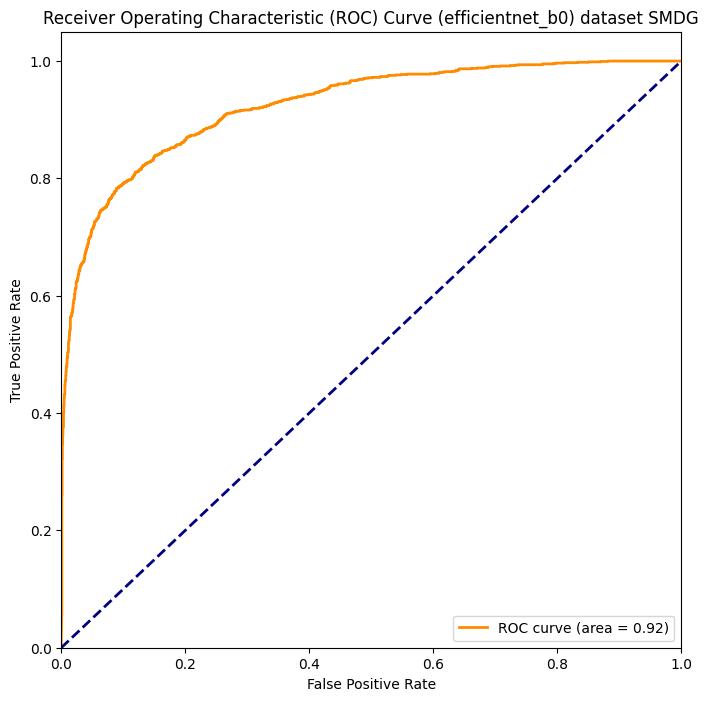

Making Heat Maps


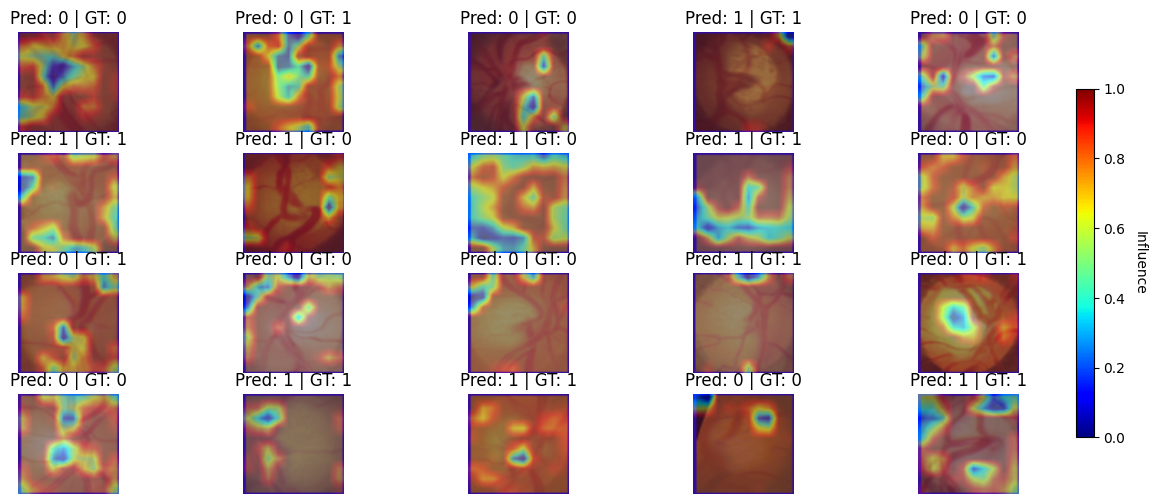

In [ ]:


from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt

import cv2
import numpy as np
import torch
import torch.nn.functional as F
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt
import random





for model_name in models_list:

        print(f"\n____________________{model_name}____________________\n")

        try:

        
            if "vit" in model_name:  # Check if the model is a Vision Transformer
                model = ViTForImageClassification.from_pretrained(
                    model_name, 
                    num_labels=num_classes, 
                    ignore_mismatched_sizes=True
                )
#                 model.to(device)
                feature_extractor = ViTImageProcessor.from_pretrained(model_name)
            else:
                model = timm.create_model(model_name, num_classes=num_classes, pretrained=False)
            

    
    

            #     # Load the best model
            model.to(device)
            
            model.load_state_dict(torch.load(f"models/{model_name}_best_model.pth"))
            print(f"Best model loaded for {model_name}")

            # Load the lists
            with open(f'models/metrics/{model_name}_training_metrics.pkl', 'rb') as f:
                metrics = pickle.load(f)
                train_loss_list = metrics['train_loss_list']
                val_loss_list = metrics['val_loss_list']
                train_accuracy_list = metrics['train_accuracy_list']
                val_accuracy_list = metrics['val_accuracy_list']
                best_model_epoch=metrics['best_model_epoch']

            print(f"Metrics loaded for {model_name}")
            print(f'Best epoch : {best_model_epoch}')

            # Plot training and validation loss
            plt.figure(figsize=(10, 5))
            plt.plot(train_loss_list, label='Train Loss')
            plt.plot(val_loss_list, label='Validation Loss')
            plt.plot(best_model_epoch, val_loss_list[best_model_epoch], 'ro', label='Best Model', markersize=5)  # 'ro' for red circle
            plt.plot(best_model_epoch, train_loss_list[best_model_epoch], 'ro',  markersize=5)  # 'ro' for red circle

            plt.title(f'Training and Validation Loss ({model_name})')
            plt.xlabel('Epochs')
            plt.ylabel('Loss')
            plt.legend()
            plt.show()

            # Plot training and validation accuracy
            plt.figure(figsize=(10, 5))
            plt.plot(train_accuracy_list, label=f'Train Accuracy ({model_name})')
            plt.plot(val_accuracy_list, label=f'Validation Accuracy ({model_name})')
            plt.plot(best_model_epoch, train_accuracy_list[best_model_epoch], 'ro', label='Best Model', markersize=5)  # 'ro' for red circle
            plt.plot(best_model_epoch, val_accuracy_list[best_model_epoch], 'ro',  markersize=5)  # 'ro' for red circle
            
            plt.title('Training and Validation Accuracy')
            plt.xlabel('Epochs')
            plt.ylabel('Accuracy')
            plt.legend()
            plt.show()

        except:
            print(f"Couldnt load model for {model_name}. Continuing")
            continue
        

        for loader_index in range(len(val_loaders)):

            val_loader=val_loaders[loader_index]
            ds_name=dataset_name[loader_index]
            print(f"Validating on {ds_name}")
            
            # Initialize lists to store true labels, predicted labels, and predicted probabilities
            true_labels = []
            predicted_labels = []
            predicted_probs = []

            # Validation loop
            model.eval()
            with torch.no_grad():
                for batch in tqdm(val_loader, desc=f"Predicting on model: {model_name} and {ds_name}"):
                    images, labels = batch
                    if "vit" in model_name:
                        images = feature_extractor(images, return_tensors="pt").to(device)
                    else:
                        images = images.to(device)
                    labels = labels.to(device)

                    # Forward pass
                    outputs = model(images)

                    # Store true labels and predicted labels
                    true_labels.extend(labels.cpu().numpy())

                    _, predicted = torch.max(outputs, 1)
                    predicted_labels.extend(predicted.cpu().numpy())

                    # Store predicted probabilities for the positive class
                    probs = torch.nn.functional.softmax(outputs, dim=1)[:, 1]
                    predicted_probs.extend(probs.cpu().numpy())

            # Generate classification report
            report = classification_report(true_labels, predicted_labels)
            print(f'Classification Report:\n {ds_name}  {report}')

            # Generate confusion matrix
            conf_matrix = confusion_matrix(true_labels, predicted_labels)

            # Plot confusion matrix
            fig, ax = plt.subplots(figsize=(6, 6))
            sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=[0, 1], yticklabels=[0, 1])
            ax.set_xlabel('Predicted Label')
            ax.set_ylabel('True Label')
            plt.title(f'Classification Report ({model_name}) dataset {ds_name}')
            plt.show()

            # Compute ROC curve and AUC
            fpr, tpr, thresholds = roc_curve(true_labels, predicted_probs)
            roc_auc = auc(fpr, tpr)

            # Plot ROC curve
            plt.figure(figsize=(8, 8))
            plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = {:.2f})'.format(roc_auc))
            plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title(f'Receiver Operating Characteristic (ROC) Curve ({model_name}) dataset {ds_name}')
            plt.legend(loc='lower right')
            plt.show()
            
            print("Making Heat Maps")
            
            # Load 10 random images from the validation set
            images = []
            labels = []
            num_images=20
            for _ in range(20):
                idx = random.randint(0, len(val_loader.dataset) - 1)
                img, label = val_loader.dataset[idx]
                images.append(img)
                labels.append(label)

            # Convert the list of images to a torch tensor
            images = torch.stack(images)
            labels = torch.tensor(labels)



            # Hook to extract the feature maps and gradients
            feature_maps = []
            gradients = []
            def forward_hook(module, input, output):
                feature_maps.append(output)
            def backward_hook(module, input, output):
                gradients.append(output[0])

            # Register the hooks
            model.blocks[-1].register_forward_hook(forward_hook)
            model.blocks[-1].register_full_backward_hook(backward_hook)


            # Forward pass and compute Grad-CAM
            # images = images.permute(0, 3, 1, 2)  # Reorder dimensions to (batch_size, channels, height, width)
            # images = images.float()  # Converts to float
            # images = images / 255.0  # Normalize to [0, 1] if your images are in the 0-255 range


            images = images.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            # Compute gradients
            outputs[:, predicted].backward(torch.ones_like(outputs[:, predicted]))

            # Compute weights
            weights = torch.mean(gradients[0], dim=(2, 3))

            # Compute Grad-CAM heatmap
            heatmaps = []
            for i in range(images.size(0)):
                heatmap = torch.sum(weights[i].view(-1, 1, 1) * feature_maps[0][i], dim=0)
                heatmap = F.relu(heatmap)
                heatmap = heatmap / torch.max(heatmap)
                heatmaps.append(heatmap.cpu().detach().numpy())

            # Convert images to NumPy array
            images_np = images.cpu().numpy()

            # Overlay heatmap on original images and display them
            fig, axes = plt.subplots(4, 5, figsize=(15, 6))
            axes = axes.flatten()
            for i in range(num_images):
                ax = axes[i]
                img = images_np[i][:3, :, :].transpose((1, 2, 0))  # Extract first 3 channels and convert from CHW to HWC format
                img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
                img = np.uint8(255 * img)  # Convert to uint8
                heatmap = heatmaps[i]
                heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
                heatmap = np.uint8(255 * heatmap)
                heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
                superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
                ax.imshow(superimposed_img)
                ax.set_title(f'Pred: {predicted[i].item()} | GT: {labels[i].item()}')
                ax.axis('off')



            # Add color bar
            sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(0, 1))
            sm.set_array([])
            cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.05)
            cbar.set_label('Influence', rotation=270, labelpad=15)

            # plt.tight_layout()
            plt.show()


In [ ]:


val_loader=val_loaders[0]

model_name= "efficientnet_b0"

model = timm.create_model(model_name, num_classes=num_classes, pretrained=False)
model.to(device)
model.load_state_dict(torch.load("/kaggle/input/efficientnet-b0-glaucoma/pytorch/best/1/models/efficientnet_b0_best_model.pth"))



# Load 10 random images from the validation set
images = []
labels = []
num_images=20
for _ in range(20):
    idx = random.randint(0, len(val_loader.dataset) - 1)
    img, label = val_loader.dataset[idx]
    images.append(img)
    labels.append(label)

# Convert the list of images to a torch tensor
images = torch.stack(images)
labels = torch.tensor(labels)



# Hook to extract the feature maps and gradients
feature_maps = []
gradients = []
def forward_hook(module, input, output):
    feature_maps.append(output)
def backward_hook(module, input, output):
    gradients.append(output[0])

# Register the hooks
model.blocks[-1].register_forward_hook(forward_hook)
model.blocks[-1].register_full_backward_hook(backward_hook)


# Forward pass and compute Grad-CAM
# images = images.permute(0, 3, 1, 2)  # Reorder dimensions to (batch_size, channels, height, width)
# images = images.float()  # Converts to float
# images = images / 255.0  # Normalize to [0, 1] if your images are in the 0-255 range


images = images.to(device)
outputs = model(images)
_, predicted = torch.max(outputs, 1)

# Compute gradients
outputs[:, predicted].backward(torch.ones_like(outputs[:, predicted]))

# Compute weights
weights = torch.mean(gradients[0], dim=(2, 3))

# Compute Grad-CAM heatmap
heatmaps = []
for i in range(images.size(0)):
    heatmap = torch.sum(weights[i].view(-1, 1, 1) * feature_maps[0][i], dim=0)
    heatmap = F.relu(heatmap)
    heatmap = heatmap / torch.max(heatmap)
    heatmaps.append(heatmap.cpu().detach().numpy())

# Convert images to NumPy array
images_np = images.cpu().numpy()

# Overlay heatmap on original images and display them
fig, axes = plt.subplots(4, 5, figsize=(15, 6))
axes = axes.flatten()
for i in range(num_images):
    ax = axes[i]
    img = images_np[i][:3, :, :].transpose((1, 2, 0))  # Extract first 3 channels and convert from CHW to HWC format
    img = (img - img.min()) / (img.max() - img.min())  # Normalize to [0, 1]
    img = np.uint8(255 * img)  # Convert to uint8
    heatmap = heatmaps[i]
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)
    ax.imshow(superimposed_img)
    ax.set_title(f'Pred: {predicted[i].item()} | GT: {labels[i].item()}')
    ax.axis('off')



# Add color bar
sm = plt.cm.ScalarMappable(cmap='jet', norm=plt.Normalize(0, 1))
sm.set_array([])
cbar = plt.colorbar(sm, ax=axes.ravel().tolist(), orientation='vertical', fraction=0.015, pad=0.05)
cbar.set_label('Influence', rotation=270, labelpad=15)

# plt.tight_layout()
plt.show()

<All keys matched successfully>

# Class wise density maps

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tqdm.auto import tqdm

# Assuming device is already set to 'cuda' if available
device='cpu'
print(device)
num_classes = 2  # Assuming binary classification
num_feature_maps = None  # This will be set after the forward hook
batch_feature_maps = []
batch_gradients = []

# Load the model to device and set it to evaluation mode
model.to(device)
model.eval()

height,width=512,512

# Initialize accumulators for heatmaps for each class
# Given image size is 512x512
class_accumulated_heatmaps = [torch.zeros((1, height,width), device=device) for _ in range(num_classes)]
total_images = 0  # Counter for total number of images processed

# Forward and backward hooks
def forward_hook(module, input, output):
    batch_feature_maps.append(output)

def backward_hook(module, input, output):
    batch_gradients.append(output[0])

# Register the hooks on the last convolutional layer
model.blocks[-1].register_forward_hook(forward_hook)
model.blocks[-1].register_full_backward_hook(backward_hook)

# Loop through the validation dataset
for imgs, _ in tqdm(val_loader, desc='Processing validation set'):
    imgs = imgs.to(device)
    outputs = model(imgs)
    one_hot_output = torch.zeros_like(outputs)

    # Backward pass for each class
    for class_idx in range(num_classes):
        model.zero_grad()
        one_hot_output.zero_()
        one_hot_output[:, class_idx] = 1
        class_output = (outputs * one_hot_output).sum()
        class_output.backward(retain_graph=True)

        # Retrieve and process feature maps and gradients
        grads = batch_gradients[-1].detach()
        fmaps = batch_feature_maps[-1].detach()
        weights = torch.mean(grads, dim=(2, 3), keepdim=True)
        class_heatmap = (weights * fmaps).sum(dim=1)
        class_heatmap = F.relu(class_heatmap)

        # Normalize the heatmap
        max_value = class_heatmap.max()
        if max_value > 0:
            class_heatmap /= max_value
        # Average the heatmaps across the batch and add a batch dimension
        averaged_class_heatmap = class_heatmap.mean(dim=0, keepdim=True).unsqueeze(0)

        # Ensure we have the correct number of dimensions
        if averaged_class_heatmap.ndim == 4:
            # Resize the averaged heatmap to match the target size (512x512)
            averaged_class_heatmap = F.interpolate(averaged_class_heatmap, size=(height,width), mode='bilinear', align_corners=False)
        else:
            # Handle unexpected number of dimensions
            raise ValueError("Unexpected number of dimensions in the averaged_class_heatmap.")

        # Remove the batch dimension after interpolation
        averaged_class_heatmap = averaged_class_heatmap.squeeze(0)

        # Accumulate the heatmaps
        class_accumulated_heatmaps[class_idx] += averaged_class_heatmap

    total_images += imgs.size(0)
    batch_feature_maps.clear()
    batch_gradients.clear()

# Average the heatmaps over all images
class_accumulated_heatmaps = [heatmap / total_images for heatmap in class_accumulated_heatmaps]

# Convert the accumulated heatmaps to numpy for visualization
class_accumulated_heatmaps_np = [heatmap.squeeze().cpu().numpy() for heatmap in class_accumulated_heatmaps]

# Visualization
fig, axes = plt.subplots(1, num_classes, figsize=(10 * num_classes, 10))
for class_idx, class_heatmap in tqdm(enumerate(class_accumulated_heatmaps_np), desc="Plotting"):
    # Normalize the heatmap to range [0, 1]
    class_heatmap_normalized = (class_heatmap - np.min(class_heatmap)) / (np.max(class_heatmap) - np.min(class_heatmap))
    
    # Resize heatmap to match the image size (512x512)
    class_heatmap_resized = cv2.resize(class_heatmap_normalized, (512, 512))
    
    # Convert to a color heatmap (expects values in the range [0, 255])
    class_heatmap_color = cv2.applyColorMap(np.uint8(255 * class_heatmap_resized), cv2.COLORMAP_JET)
    
    axes[class_idx].imshow(class_heatmap_color)
    axes[class_idx].set_title(f'Class {class_idx} Average Heatmap')
    axes[class_idx].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
torch.cuda.empty_cache()